This tutorial is based on PyTorch's tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html and contains the code snippets from it:  
- device test
- transform, trainset, trainloader, testset, testloader, classes
- imshow()
- accuracy(), accuracy_batch()
- training loop, evaluation routine, and visualizers

The license of the original tutorial is the 3-Clause BSD License.  
See LICENSE for detail.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# To monitor the server's GPU installation and usage: log in the server and run `nvidia-smi`.
# It shows the list of GPUs online and their utilization.

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)




cuda:0


In [3]:
epochs = 10
batch_size_train = 128
batch_size_test = 128
num_shown_images = 8

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./drive/My Drive/Colab Notebooks/b3_proj_2022/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./drive/My Drive/Colab Notebooks/b3_proj_2022/data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


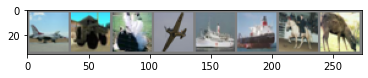

plane truck  bird plane  ship  ship horse  deer


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:num_shown_images]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(num_shown_images)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F


# Complete this network model to be VGG11, then customize it!

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1, bias=False)
        self.bn_conv1_1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        
        # IMPLEMENT BY YOURSELF!
        
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.bn_conv3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1, bias=False)
        self.bn_conv3_2 = nn.BatchNorm2d(256)
        
        # IMPLEMENT BY YOURSELF!
        
        self.fc1 = nn.Linear(512, 4096, bias=False)
        self.bn_fc1 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 4096, bias=False)
        self.bn_fc2 = nn.BatchNorm1d(4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn_conv1_1(self.conv1_1(x))))
        
        # IMPLEMENT BY YOURSELF!
        
        x = F.relu(self.bn_conv3_1(self.conv3_1(x)))
        x = self.pool(F.relu(self.bn_conv3_2(self.conv3_2(x))))
        
        # IMPLEMENT BY YOURSELF!
        
        x = x.view(-1, 512 * 1 * 1)
        # Why spatial size is 1x1 here, while the input was in 32x32? Hint: which opereations do the spatial resampling?
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.fc3(x)
        return x


net = Net()


In [ ]:
net.to(device)

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Learning rate and momentum is also hyper-parameters to be adjusted manually.


In [9]:
def accuracy(loader, model, dev=None):
    total = 0
    correct = 0
    with torch.no_grad():
        for data in loader:
            if dev is None:
                images, labels = data
            else:
                images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100.0 * correct / total

def accuracy_batch(output, label):
    total = 0
    correct = 0
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    return 100.0 * correct / total

In [ ]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f, train batch acc: %2d %%' %
                  (epoch + 1, i + 1, running_loss, accuracy_batch(outputs, labels)))
            running_loss = 0.0
    
    # Evaluate intermediate result
    net.eval()
    print('[%d,      ] test acc: %2d %%' %
          (epoch + 1, accuracy(testloader, net, dev=device)))
   

print('Finished Training')

In [11]:
PATH = './01_vgg.pth'
# Be careful not to overwrite your precious learned parameter files.

torch.save(net.state_dict(), PATH)

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.eval()

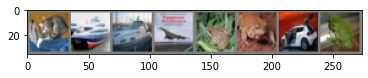

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog


In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images[:num_shown_images]
labels = labels[:num_shown_images]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(num_shown_images)))

In [14]:
outputs = net(images)

In [15]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(num_shown_images)))

Predicted:    cat  ship  ship plane  frog  frog   car  frog


In [16]:
print('Accuracy of the network on the 10000 test images: %d %%' % accuracy(testloader, net))

Accuracy of the network on the 10000 test images: 76 %


In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane : 81 %
Accuracy of   car : 87 %
Accuracy of  bird : 63 %
Accuracy of   cat : 52 %
Accuracy of  deer : 75 %
Accuracy of   dog : 69 %
Accuracy of  frog : 81 %
Accuracy of horse : 82 %
Accuracy of  ship : 83 %
Accuracy of truck : 82 %
